In [4]:
import os
import subprocess
from nipype.interfaces import fsl

# FSL 환경 설정
os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')


Starting Slice Timing Correction
Input file: /home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz
Output file: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/slice_timing_output.nii.gz


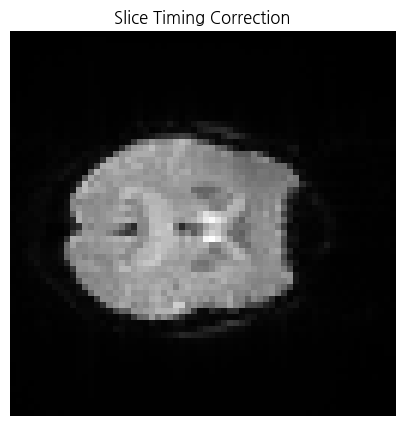

Slice Timing Correction completed. Output saved to: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/slice_timing_output.nii.gz

Starting Motion Correction (MCFLIRT)
Input file: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/slice_timing_output.nii.gz
Output file: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/mcflirt_output.nii.gz


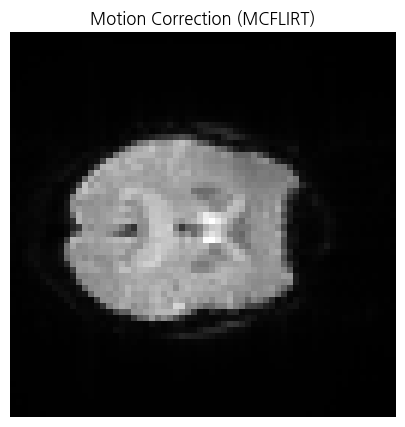

Motion Correction (MCFLIRT) completed. Output saved to: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/mcflirt_output.nii.gz

Starting Brain Extraction (BET)
Input file: /home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/anat2/NIFTI/sub-OAS30011_ses-d0055_T1w.nii.gz
Output file: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/bet_output.nii.gz


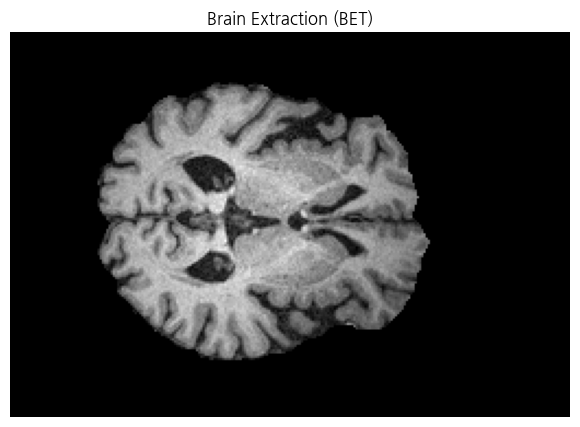

Brain Extraction (BET) completed. Output saved to: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/bet_output.nii.gz

Starting /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/func_to_struct_output.nii.gz
Input file: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/mcflirt_output.nii.gz
Output file: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/bet_output.nii.gz
240709-10:45:11,526 nipype.interface INFO:
	 stderr 2024-07-09T10:45:11.526690:Unrecognised option t
Error in /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/func_to_struct_output.nii.gz: No such file or directory '/home/minyoungxi/MINYOUNGXI/XFL/FSL/Functional to Structural Registration' for output 'out_file' of a FLIRT interface
Functional to Structural Registration failed. Stopping preprocessing.

Starting Spatial Smoothing
Input file: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/func_to_struct_output.nii.gz
Output file: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/smooth_output.nii.gz
Error: Input file n

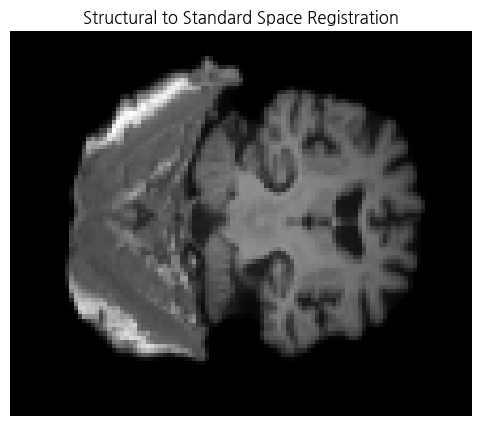

Structural to Standard Space Registration completed. Output saved to: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/struct_to_standard_output.nii.gz

Starting Functional to Standard Space Registration
Input file: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/highpass_output.nii.gz
Output file: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/func_to_standard_output.nii.gz
Error: Input file not found: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/highpass_output.nii.gz
Functional to Standard Space Registration failed. Stopping preprocessing.

All preprocessing steps completed.
Summary of outputs:
Slice Timing Correction: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/slice_timing_output.nii.gz
Motion Correction: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/mcflirt_output.nii.gz
Brain Extraction: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/bet_output.nii.gz
Functional to Structural Registration: /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/func_to_struct_o

: 

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nipype.interfaces import fsl
from nipype.algorithms.confounds import TSNR

def visualize_slice(image, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def run_and_check(func, input_file, output_file, title, *args):
    print(f"\nStarting {title}")
    print(f"Input file: {input_file}")
    print(f"Output file: {output_file}")
    
    if not os.path.exists(input_file):
        print(f"Error: Input file not found: {input_file}")
        return None
    
    try:
        result = func(input_file, output_file, *args)
        if os.path.exists(output_file):
            img = nib.load(output_file)
            data = img.get_fdata()
            if data.ndim == 4:
                data = np.mean(data, axis=3) 
            mid_slice = data.shape[2] // 2
            visualize_slice(data[:, :, mid_slice], title)
            print(f"{title} completed. Output saved to: {output_file}")
            return result
        else:
            print(f"Error: {title} failed. Output not found at {output_file}")
            return None
    except Exception as e:
        print(f"Error in {title}: {str(e)}")
        return None

func_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz"
struct_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/anat2/NIFTI/sub-OAS30011_ses-d0055_T1w.nii.gz"
standard_file = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_2mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed'

os.makedirs(output_dir, exist_ok=True)

def run_slice_timing(in_file, out_file):
    slicetimer = fsl.SliceTimer()
    slicetimer.inputs.in_file = in_file
    slicetimer.inputs.out_file = out_file
    slicetimer.inputs.time_repetition = 2.0  # TR in seconds, adjust as needed
    slicetimer.inputs.index_dir = False  # False for ascending, True for descending
    return slicetimer.run()

def run_mcflirt(in_file, out_file):
    mcflirt = fsl.MCFLIRT()
    mcflirt.inputs.in_file = in_file
    mcflirt.inputs.out_file = out_file
    mcflirt.inputs.save_plots = True
    return mcflirt.run()

def run_bet(in_file, out_file):
    bet = fsl.BET()
    bet.inputs.in_file = in_file
    bet.inputs.out_file = out_file
    bet.inputs.frac = 0.5
    return bet.run()

def run_func_to_struct(func_file, struct_file, out_file):
    flirt = fsl.FLIRT()
    flirt.inputs.in_file = func_file
    flirt.inputs.reference = struct_file
    flirt.inputs.out_file = out_file
    flirt.inputs.out_matrix_file = out_file + '.mat'
    flirt.inputs.dof = 6
    return flirt.run()
    
def run_smooth(in_file, out_file, fwhm=5):
    smooth = fsl.maths.IsotropicSmooth()
    smooth.inputs.in_file = in_file
    smooth.inputs.fwhm = fwhm
    smooth.inputs.out_file = out_file
    return smooth.run()

def run_highpass(in_file, out_file, highpass_sigma=50):
    highpass = fsl.TemporalFilter()
    highpass.inputs.in_file = in_file
    highpass.inputs.highpass_sigma = highpass_sigma
    highpass.inputs.out_file = out_file
    return highpass.run()

def run_tsnr(in_file, out_file):
    tsnr = TSNR()
    tsnr.inputs.in_file = in_file
    tsnr.inputs.out_file = out_file
    return tsnr.run()

def run_struct_to_standard(in_file, out_file, ref_file):
    flirt = fsl.FLIRT(in_file=in_file, reference=ref_file, out_file=out_file, out_matrix_file=out_file + '.mat')
    return flirt.run()

def apply_transform(in_file, out_file, ref_file, matrix_file):
    apply_xfm = fsl.ApplyXFM()
    apply_xfm.inputs.in_file = in_file
    apply_xfm.inputs.reference = ref_file
    apply_xfm.inputs.out_file = out_file
    apply_xfm.inputs.in_matrix_file = matrix_file
    return apply_xfm.run()

# Run preprocessing steps
slice_timing_output = os.path.join(output_dir, "slice_timing_output.nii.gz")
slice_timing_result = run_and_check(run_slice_timing, func_file, slice_timing_output, "Slice Timing Correction")
if slice_timing_result is None:
    print("Slice Timing Correction failed. Stopping preprocessing.")
    exit()

mcflirt_output = os.path.join(output_dir, "mcflirt_output.nii.gz")
mcflirt_result = run_and_check(run_mcflirt, slice_timing_output, mcflirt_output, "Motion Correction (MCFLIRT)")
if mcflirt_result is None:
    print("Motion Correction failed. Stopping preprocessing.")
    exit()

bet_output = os.path.join(output_dir, "bet_output.nii.gz")
bet_result = run_and_check(run_bet, struct_file, bet_output, "Brain Extraction (BET)")
if bet_result is None:
    print("Brain Extraction failed. Stopping preprocessing.")
    exit()

func_to_struct_output = os.path.join(output_dir, "func_to_struct_output.nii.gz")
func_to_struct_result = run_and_check(run_func_to_struct, mcflirt_output, bet_output, func_to_struct_output, "Functional to Structural Registration")
if func_to_struct_result is None:
    print("Functional to Structural Registration failed. Stopping preprocessing.")
    exit()

smooth_output = os.path.join(output_dir, "smooth_output.nii.gz")
smooth_result = run_and_check(run_smooth, func_to_struct_output, smooth_output, "Spatial Smoothing", 5)
if smooth_result is None:
    print("Spatial Smoothing failed. Stopping preprocessing.")
    exit()

highpass_output = os.path.join(output_dir, "highpass_output.nii.gz")
highpass_result = run_and_check(run_highpass, smooth_output, highpass_output, "Temporal Filtering (High-pass)", 50)
if highpass_result is None:
    print("Temporal Filtering failed. Stopping preprocessing.")
    exit()

tsnr_output = os.path.join(output_dir, "tsnr_output.nii.gz")
tsnr_result = run_and_check(run_tsnr, highpass_output, tsnr_output, "TSNR Calculation")
if tsnr_result is None:
    print("TSNR Calculation failed. Stopping preprocessing.")
    exit()

struct_to_standard_output = os.path.join(output_dir, "struct_to_standard_output.nii.gz")
struct_to_standard_result = run_and_check(run_struct_to_standard, bet_output, struct_to_standard_output, "Structural to Standard Space Registration", standard_file)
if struct_to_standard_result is None:
    print("Structural to Standard Space Registration failed. Stopping preprocessing.")
    exit()

func_to_standard_output = os.path.join(output_dir, "func_to_standard_output.nii.gz")
func_to_standard_result = run_and_check(apply_transform, highpass_output, func_to_standard_output, "Functional to Standard Space Registration", 
                                        standard_file, struct_to_standard_output + '.mat')
if func_to_standard_result is None:
    print("Functional to Standard Space Registration failed. Stopping preprocessing.")
    exit()

print("\nAll preprocessing steps completed.")
print("Summary of outputs:")
print(f"Slice Timing Correction: {slice_timing_output}")
print(f"Motion Correction: {mcflirt_output}")
print(f"Brain Extraction: {bet_output}")
print(f"Functional to Structural Registration: {func_to_struct_output}")
print(f"Spatial Smoothing: {smooth_output}")
print(f"Temporal Filtering: {highpass_output}")
print(f"TSNR Calculation: {tsnr_output}")
print(f"Structural to Standard Space Registration: {struct_to_standard_output}")
print(f"Functional to Standard Space Registration: {func_to_standard_output}")

In [12]:
import os
import nibabel as nib
import numpy as np
import torch
from nipype.interfaces import fsl

def run_mcflirt(in_file, out_file):
    mcflirt = fsl.MCFLIRT(in_file=in_file, out_file=out_file, save_plots=True)
    return mcflirt.run()

def run_slicetimer(in_file, out_file):
    slicetimer = fsl.SliceTimer(in_file=in_file, out_file=out_file)
    return slicetimer.run()

def run_smooth(in_file, out_file, fwhm=5):
    smooth = fsl.maths.IsotropicSmooth(in_file=in_file, fwhm=fwhm, out_file=out_file)
    return smooth.run()

def run_highpass(in_file, out_file, highpass_sigma=50):
    highpass = fsl.TemporalFilter(in_file=in_file, highpass_sigma=highpass_sigma, out_file=out_file)
    return highpass.run()

def run_bet(in_file, out_file):
    bet = fsl.BET(in_file=in_file, out_file=out_file, frac=0.5)
    return bet.run()

def run_flirt(in_file, ref_file, out_file, dof=6):
    flirt = fsl.FLIRT(in_file=in_file, reference=ref_file, out_file=out_file, out_matrix_file=out_file + '.mat', dof=dof)
    return flirt.run()

def apply_xfm(in_file, ref_file, out_file, matrix_file):
    apply_xfm = fsl.ApplyXFM()
    apply_xfm.inputs.in_file = in_file
    apply_xfm.inputs.reference = ref_file
    apply_xfm.inputs.out_file = out_file
    apply_xfm.inputs.in_matrix_file = matrix_file
    apply_xfm.inputs.apply_xfm = True
    return apply_xfm.run()

def preprocess_fmri(func_file, struct_file, standard_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Motion Correction
    mcflirt_output = os.path.join(output_dir, "mcflirt_output.nii.gz")
    run_mcflirt(func_file, mcflirt_output)

    # Slice Timing Correction
    slicetimer_output = os.path.join(output_dir, "slicetimer_output.nii.gz")
    run_slicetimer(mcflirt_output, slicetimer_output)

    # Spatial Smoothing
    smooth_output = os.path.join(output_dir, "smooth_output.nii.gz")
    run_smooth(slicetimer_output, smooth_output)

    # Temporal Filtering
    highpass_output = os.path.join(output_dir, "highpass_output.nii.gz")
    run_highpass(smooth_output, highpass_output)

    # Brain Extraction on structural image
    bet_output = os.path.join(output_dir, "bet_output.nii.gz")
    run_bet(struct_file, bet_output)

    # Registration of functional to structural
    func_to_struct_output = os.path.join(output_dir, "func_to_struct.nii.gz")
    run_flirt(highpass_output, bet_output, func_to_struct_output, dof=6)

    # Registration of structural to MNI space
    struct_to_mni_output = os.path.join(output_dir, "struct_to_mni.nii.gz")
    run_flirt(bet_output, standard_file, struct_to_mni_output, dof=12)

    # Apply combined transformation to functional data
    mni_output = os.path.join(output_dir, "mni_output.nii.gz")
    apply_xfm(func_to_struct_output, standard_file, mni_output, struct_to_mni_output + '.mat')

    return mni_output

# 사용 예
func_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz"
struct_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/anat2/NIFTI/sub-OAS30011_ses-d0055_T1w.nii.gz"
standard_file = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_2mm_brain.nii.gz')
output_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed"

final_output = preprocess_fmri(func_file, struct_file, standard_file, output_dir)

# 전처리된 데이터를 PyTorch 텐서로 변환
preprocessed_data = nib.load(final_output).get_fdata()
preprocessed_tensor = torch.from_numpy(preprocessed_data).float()

# 결과 확인
print(f"Original functional data shape: {nib.load(func_file).shape}")
print(f"Preprocessed MNI data shape: {preprocessed_data.shape}")
print(f"Preprocessed tensor shape: {preprocessed_tensor.shape}")

240709-11:14:36,297 nipype.interface INFO:
	 stderr 2024-07-09T11:14:36.297085:Warning: An input intended to be a single 3D volume has multiple timepoints. Input will be truncated to first volume, but this functionality is deprecated and will be removed in a future release.
240709-11:14:42,32 nipype.interface INFO:
	 stderr 2024-07-09T11:14:42.032080:Warning: An input intended to be a single 3D volume has multiple timepoints. Input will be truncated to first volume, but this functionality is deprecated and will be removed in a future release.
Original functional data shape: (64, 64, 36, 164)
Preprocessed MNI data shape: (91, 109, 91)
Preprocessed tensor shape: torch.Size([91, 109, 91])


MNI output does not have a time dimension. Cannot plot time series.


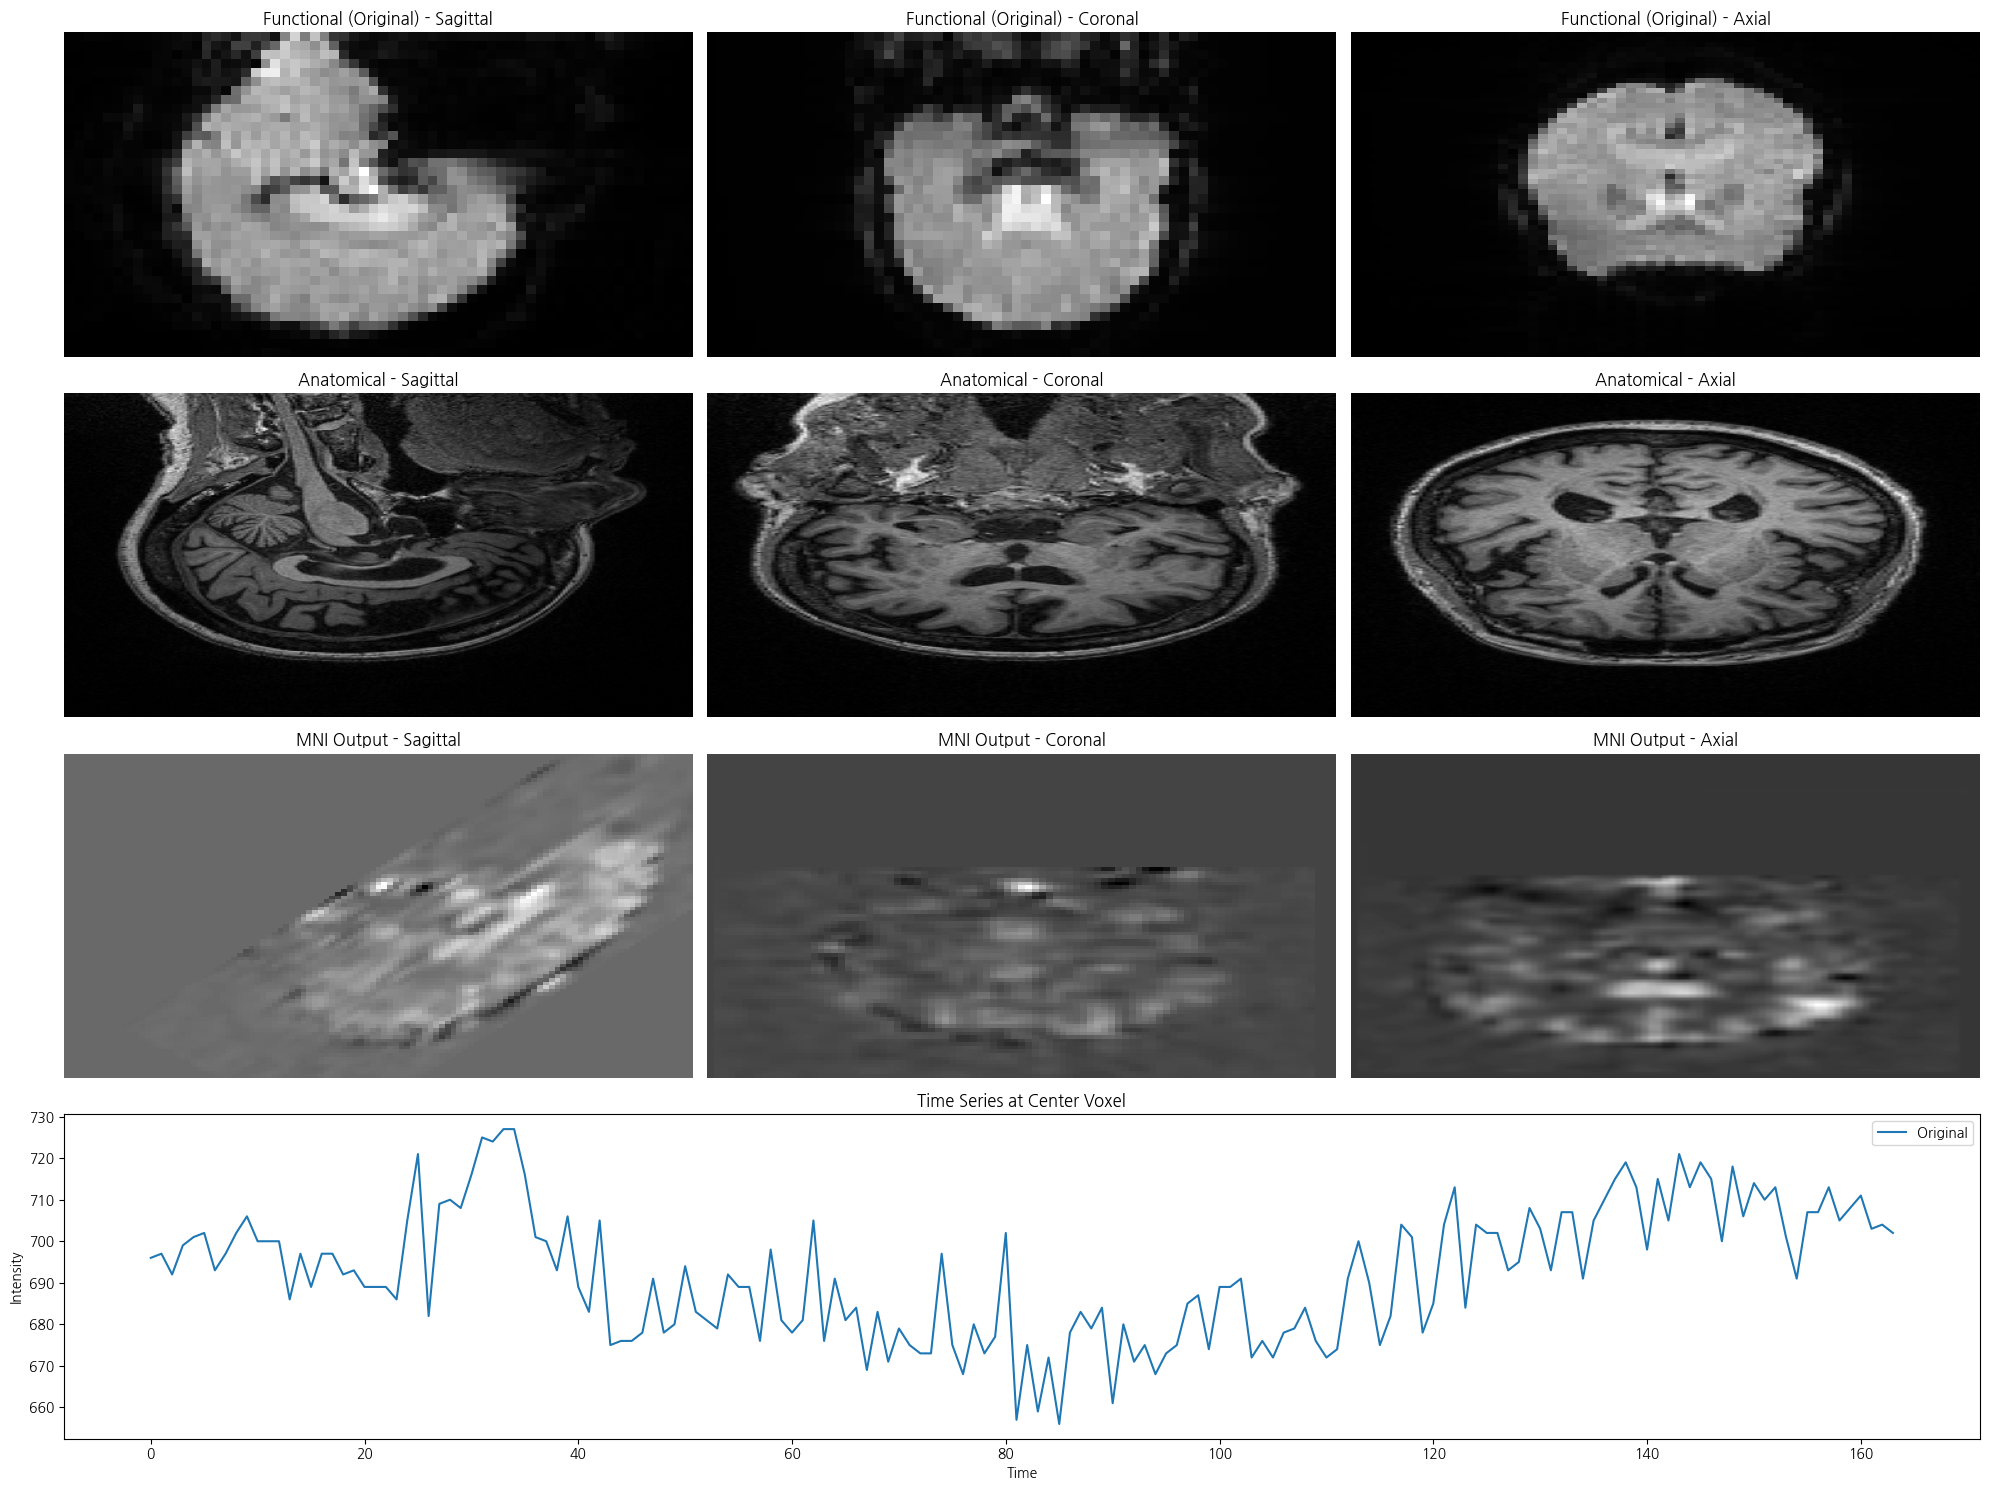

Functional data shape: (64, 64, 36, 164)
Anatomical data shape: (176, 256, 256)
MNI output data shape: (91, 109, 91)


In [13]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def load_and_prepare_image(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    if data.ndim == 4: 
        return data, np.mean(data, axis=3)  
    else:
        return data, data

def plot_central_slices(ax, data, title):
    if data.ndim == 3:
        slice_x = data[data.shape[0]//2, :, :]
        slice_y = data[:, data.shape[1]//2, :]
        slice_z = data[:, :, data.shape[2]//2]
    else:  # 4D data
        slice_x = data[data.shape[0]//2, :, :, 0]
        slice_y = data[:, data.shape[1]//2, :, 0]
        slice_z = data[:, :, data.shape[2]//2, 0]
    
    ax[0].imshow(slice_x.T, cmap='gray', aspect='auto')
    ax[1].imshow(slice_y.T, cmap='gray', aspect='auto')
    ax[2].imshow(slice_z.T, cmap='gray', aspect='auto')
    ax[0].set_title(f'{title} - Sagittal')
    ax[1].set_title(f'{title} - Coronal')
    ax[2].set_title(f'{title} - Axial')
    for a in ax:
        a.axis('off')

def plot_time_series(ax, data):
    if data.ndim == 4:
        center = (data.shape[0]//2, data.shape[1]//2, data.shape[2]//2)
        time_series = data[center[0], center[1], center[2], :]
        ax.plot(time_series)
        ax.set_title('Time Series at Center Voxel')
        ax.set_xlabel('Time')
        ax.set_ylabel('Intensity')
    else:
        print(f"Cannot plot time series for data with shape {data.shape}")

# 파일 경로 설정
func_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz"
anat_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/anat2/NIFTI/sub-OAS30011_ses-d0055_T1w.nii.gz"
mni_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/mni_output.nii.gz"

# 데이터 로드
func_data, func_mean = load_and_prepare_image(func_file)
anat_data, _ = load_and_prepare_image(anat_file)
mni_data, mni_mean = load_and_prepare_image(mni_file)

# 시각화
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(4, 3)

# Functional image
ax_func = [fig.add_subplot(gs[0, i]) for i in range(3)]
plot_central_slices(ax_func, func_mean, 'Functional (Original)')

# Anatomical image
ax_anat = [fig.add_subplot(gs[1, i]) for i in range(3)]
plot_central_slices(ax_anat, anat_data, 'Anatomical')

# MNI output
ax_mni = [fig.add_subplot(gs[2, i]) for i in range(3)]
plot_central_slices(ax_mni, mni_mean, 'MNI Output')

# Time series
ax_time = fig.add_subplot(gs[3, :])
plot_time_series(ax_time, func_data)  # Original func data
if mni_data.ndim == 4:
    plot_time_series(ax_time, mni_data)   # Preprocessed MNI data
    ax_time.legend(['Original', 'Preprocessed'])
else:
    ax_time.legend(['Original'])
    print("MNI output does not have a time dimension. Cannot plot time series.")

plt.tight_layout()
plt.show()

# 데이터 크기 출력
print(f"Functional data shape: {func_data.shape}")
print(f"Anatomical data shape: {anat_data.shape}")
print(f"MNI output data shape: {mni_data.shape}")

In [9]:
print(f"Functional data shape: {func_data.shape}")
print(f"MNI output data shape: {mni_data.shape}")

Functional data shape: (64, 64, 36, 164)
MNI output data shape: (91, 109, 91)
